# Dog Identification (1 - Exploration)

The task here is to develop a CNN algorthim that, given an image of a dog, identifes its breed. If supplied an image of a human, the code will identify the resembling dog breed.

This first notebook explores the data.

## Import Libraries

In [22]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

%matplotlib inline

## Download Data

In [2]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages

--2020-02-22 16:53:33--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.192
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  11.1MB/s    in 99s     

2020-02-22 16:55:12 (11.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [3]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip lfw

--2020-02-22 16:55:22--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.80
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196739509 (188M) [application/zip]
Saving to: ‘lfw.zip’

lfw.zip             100%[===================>] 187.62M  10.6MB/s    in 18s     

2020-02-22 16:55:41 (10.3 MB/s) - ‘lfw.zip’ saved [196739509/196739509]

Archive:  lfw.zip
   creating: lfw/
  inflating: lfw/.DS_Store           
   creating: __MACOSX/
   creating: __MACOSX/lfw/
  inflating: __MACOSX/lfw/._.DS_Store  
   creating: lfw/Aaron_Eckhart/
  inflating: lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg  
   creating: __MACOSX/lfw/Aaron_Eckhart/
  inflating: __MACOSX/lfw/Aaron_Eckhart/._Aaron_Eckhart_0001.jpg  
  inflating: __MACOSX/lfw/._Aaron_Eckhart  
   creating: lfw/Aaron_Guiel/
  inflating: lfw/Aaro

## Import Dataset

In [2]:
# load filenames for humans and dogs
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print the number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


## Detect Humans

Use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on github. We have downloaded one of these detectors and stored it in the haarcascades directory. 

In [3]:
!pip install opencv-python

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Number of faces detected: 1


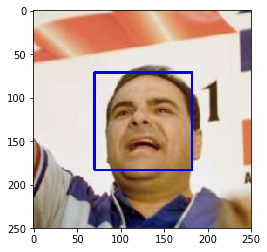

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human Face Detector

A function that returns *True* if a human face is detected in an image and *False* otherwise

In [5]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Test the accuracy of the function

In [6]:
human_files_test = human_files[:100]
dog_files_test = dog_files[:100]

human_num = 0
for img in tqdm(human_files_test):
    if face_detector(img):
        human_num += 1
        
dog_num = 0
for img in tqdm(dog_files_test):
    if face_detector(img):
        dog_num += 1

print(str(human_num) + "% of humans were detected as humans")
print(str(dog_num) + "% of dogs were detected as humans")

97% of humans were detected as humans
9% of dogs were detected as humans


## Detect Dogs

Use a a pre-trained model to detect dogs in images.

### Obtain Pre trained VCG-16 Model

Download the VCG-16 model with pretained weights

In [11]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    vgg16 = vgg16.cuda()

### Make Predictions with a Pre-trained Model

In [16]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

def vgg16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path    
    Args:
        img_path: path to an image        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''   
    
    # Load the image from provided path
    img = Image.open(img_path) 
        
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])
    img_tensor = preprocess(img).float()
    
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    
    # Now that we have preprocessed our img, we need to convert it into a variable
    # A PyTorch Variable is a wrapper around a PyTorch Tensor.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable    
    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())
        
    vgg16.eval()
    output = vgg16(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()
    #Variable has a .data attribute. This is a torch Tensor, which has a .numpy() method, 
    #which gives us a numpy array. We can call .argmax() on the numpy array to get the index of the maximum element. 
    #This is the predicted class. We find the value with that key from labels and we get our class label
    predict_index = output.data.numpy().argmax() # Our prediction will be the index of the class label with the largest value.
    return predict_index # predicted class index

The VGG16 model has a [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) of which dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [17]:
# func returns true if a dog is detected in the img
def dog_detector(img_path):
    prediction = vgg16_predict(img_path)
    return ((prediction <= 268)) & (prediction >= 151)

In [21]:
human_num = 0
for img in tqdm(human_files_test):
    if dog_detector(img):
        human_num += 1
        
dog_num = 0
for img in tqdm(dog_files_test):
    if dog_detector(img):
        dog_num += 1

print(str(human_num) + "% of humans were detected as humans")
print(str(dog_num) + "% of dogs were detected as humans")

100%|██████████| 100/100 [00:03<00:00, 25.74it/s]

1% of humans were detected as humans
100% of dogs were detected as humans


### Make Predictions with another algorthim

Use the [squeezenet](https://pytorch.org/hub/pytorch_vision_squeezenet) model to test the dog dataset again.

In [40]:
# define model
model_squeeze = models.squeezenet1_1(pretrained = True)
    
def squeeze_predict(img_path, model):
    
    img = Image.open(img_path) # Load the image from provided path
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    preprocess = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])
    
    img_tensor = preprocess(img).float()   
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable
    #if use_cuda:
        #img_tensor = Variable(img_tensor.cuda())
        
    model.eval()
    output = model(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()
    predict_index = output.data.numpy().argmax() # Our prediction will be the index of the class label with the largest value.
    
    return predict_index # predicted class index

In [41]:
# func returns true if a dog is detected in the img
def dog_detector_squeeze(img_path, model):
    prediction = squeeze_predict(img_path, model)
    return ((prediction <= 268) & (prediction >= 151))

In [42]:
human_num = 0
for img in tqdm(human_files_test):
    if dog_detector_squeeze(img, model_squeeze):
        human_num += 1
        
dog_num = 0
for img in tqdm(dog_files_test):
    if dog_detector_squeeze(img, model_squeeze):
        dog_num += 1

print(str(human_num) + "% of humans were detected as humans")
print(str(dog_num) + "% of dogs were detected as humans")


100%|██████████| 100/100 [00:03<00:00, 32.93it/s]

100%|██████████| 100/100 [00:04<00:00, 24.30it/s][A

1% of humans were detected as humans
99% of dogs were detected as humans
